## Lasso / Ridge / ElasticNet / Unregularized Linear Regression on imdb movie reviews for rating prediction

In [1]:
import pickle
import os
ROOT_PATH = '../../'
data_path = os.path.join(ROOT_PATH,'data/processed/imdb/data.pickle')

with open(data_path,"rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [2]:
print([el.shape for el in [X_train,X_test,y_train,y_test]])

[(10000, 51563), (25000, 51563), (10000,), (25000,)]


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
counter = 1
prev_mse = float('inf')
while True:
    lasso = Lasso(alpha=10**(-counter), max_iter=10000).fit(X_train, y_train)
    print(f"Alpha = 1e-{counter}")
    current_mse =  mean_squared_error(y_test, lasso.predict(X_test))
    print("Lasso MSE:", current_mse)
    print("Number of nonzero coefficients (Lasso):", (lasso.coef_ != 0).sum())
    if current_mse > prev_mse:
        break
    counter += 1
    prev_mse = current_mse


ols = LinearRegression().fit(X_train, y_train)
print("Unregularized MSE:", mean_squared_error(y_test, ols.predict(X_test)))

Alpha = 1e-1
Lasso MSE: 12.185948762000002
Number of nonzero coefficients (Lasso): 0
Alpha = 1e-2
Lasso MSE: 9.864356255098716
Number of nonzero coefficients (Lasso): 17
Alpha = 1e-3
Lasso MSE: 5.905852426004078
Number of nonzero coefficients (Lasso): 296
Alpha = 1e-4
Lasso MSE: 5.63008355508579
Number of nonzero coefficients (Lasso): 3905
Alpha = 1e-5
Lasso MSE: 8.64953476610619
Number of nonzero coefficients (Lasso): 9179
Unregularized MSE: 7.5115841696788115


In [5]:
from sklearn.model_selection import GridSearchCV
import numpy as np

alphas = np.concatenate([np.linspace(1e-5,1e-4,10),np.linspace(1e-4,1e-3,10)])
lasso = Lasso(max_iter=10000)
print(f"Searching for alphas: {alphas}")
grid = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error',verbose=2,n_jobs=-1)
grid.fit(X_train, y_train)
  
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best alpha:", grid.best_params_['alpha'])
lasso_alpha = grid.best_params_['alpha']
print("Test MSE:", mse)

Searching for alphas: [1.e-05 2.e-05 3.e-05 4.e-05 5.e-05 6.e-05 7.e-05 8.e-05 9.e-05 1.e-04
 1.e-04 2.e-04 3.e-04 4.e-04 5.e-04 6.e-04 7.e-04 8.e-04 9.e-04 1.e-03]
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha: 0.00019999999999999998
Test MSE: 5.272566738893961


In [6]:
import numpy as np
import pandas as pd

results = grid.cv_results_
# print(results.keys())
alphas = results["param_alpha"].data.astype(float)
rmse = -results["mean_test_score"]   # convert neg RMSE → RMSE

df = pd.DataFrame({
    "alpha": alphas,
    "mse": rmse
}).sort_values("alpha")

print(df)

      alpha       mse
0   0.00001  8.107575
1   0.00002  7.449823
2   0.00003  6.979482
3   0.00004  6.626617
4   0.00005  6.350290
5   0.00006  6.137214
6   0.00007  5.954673
7   0.00008  5.801787
8   0.00009  5.677251
10  0.00010  5.577282
9   0.00010  5.577282
11  0.00020  5.190487
12  0.00030  5.205128
13  0.00040  5.309904
14  0.00050  5.424642
15  0.00060  5.536266
16  0.00070  5.637450
17  0.00080  5.730562
18  0.00090  5.818388
19  0.00100  5.902932


In [7]:
print("Best alpha:", grid.best_params_['alpha'])
print("Test MSE:", mse)

Best alpha: 0.00019999999999999998
Test MSE: 5.272566738893961


In [64]:
from sklearn.linear_model import Ridge

counter = -4
prev_mse = float('inf')
threshold = 1e-4
while True:
    model = Ridge(alpha=10**(counter), max_iter=10000).fit(X_train, y_train)
    print(f"Alpha = 1e{counter}")
    current_mse =  mean_squared_error(y_test, model.predict(X_test))
    print("Ridge MSE:", current_mse)
    print("Number of nonzero coefficients (Ridge) > 1e-4:", (np.abs(model.coef_) > threshold).sum())
    if current_mse > prev_mse:
        break
    counter += 1
    prev_mse = current_mse


ols = LinearRegression().fit(X_train, y_train)
print("Unregularized MSE:", mean_squared_error(y_test, ols.predict(X_test)))


Alpha = 1e-4
Ridge MSE: 7.508158970260137
Number of nonzero coefficients (Ridge) > 1e-4: 51562
Alpha = 1e-3
Ridge MSE: 7.479471325017254
Number of nonzero coefficients (Ridge) > 1e-4: 51562
Alpha = 1e-2
Ridge MSE: 7.229580241479174
Number of nonzero coefficients (Ridge) > 1e-4: 51561
Alpha = 1e-1
Ridge MSE: 6.129913447585212
Number of nonzero coefficients (Ridge) > 1e-4: 51557
Alpha = 1e0
Ridge MSE: 5.107657354451006
Number of nonzero coefficients (Ridge) > 1e-4: 51553
Alpha = 1e1
Ridge MSE: 6.21622444239867
Number of nonzero coefficients (Ridge) > 1e-4: 51487
Unregularized MSE: 7.5115841696788115


In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

alphas = np.concatenate([np.linspace(1e-1,1e-0,10),np.linspace(1,10,10)])
lasso = Pipeline([
    ("model",Ridge(max_iter=10000))
])
print(f"Searching for alphas: {alphas}")
grid = GridSearchCV(lasso, param_grid={'model__alpha': alphas}, cv=5, scoring='neg_mean_squared_error',verbose=2,n_jobs=-1)
grid.fit(X_train, y_train)
  
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best alpha:", grid.best_params_['model__alpha'])
ridge_alpha = grid.best_params_['model__alpha']
print("Test MSE:", mse)

Searching for alphas: [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.   2.   3.   4.
  5.   6.   7.   8.   9.  10. ]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best alpha: 0.9
Test MSE: 5.1200774715420785


In [10]:
import numpy as np
import pandas as pd

results = grid.cv_results_
# print(results.keys())
alphas = results["param_model__alpha"].data.astype(float)
rmse = -results["mean_test_score"]   # convert neg RMSE → RMSE

df = pd.DataFrame({
    "alpha": alphas,
    "mse": rmse
}).sort_values("alpha")

print(df)

    alpha       mse
0    0.01  6.246990
1    0.02  6.104864
2    0.03  5.986805
3    0.04  5.885664
4    0.05  5.798229
5    0.06  5.722801
6    0.07  5.655493
7    0.08  5.596025
8    0.09  5.542910
10   0.10  5.494426
9    0.10  5.494426
11   0.20  5.189401
12   0.30  5.040636
13   0.40  4.957859
14   0.50  4.909389
15   0.60  4.881217
16   0.70  4.866379
17   0.80  4.860169
18   0.90  4.860020
19   1.00  4.864810


In [11]:
from sklearn.linear_model import ElasticNetCV
param_grid = {
    "alpha": np.logspace(-4, 1, 10),     # regularization strength
    # "l1_ratio": np.linspace(0, 1, 5)    # interpolation between L2 and L1
}
NUM_SAMPLES = 1000
enet = ElasticNetCV(l1_ratio=0.5,alphas=param_grid['alpha'])
enet.fit(X_train[:NUM_SAMPLES], y_train[:NUM_SAMPLES])

print("Best alpha:", enet.alpha_)
enet_alpha = enet.alpha_
# print("Best l1 ratio:", enet.l1_ratio_)

Best alpha: 0.0001


In [12]:
from sklearn.linear_model import ElasticNetCV
param_grid = {
    "alpha": np.concatenate([np.linspace(1e-4,1e-3,10),np.linspace(1e-3, 1e-2, 10)])     # regularization strength
}
NUM_SAMPLES = 1000
enet = ElasticNetCV(l1_ratio=0.5,alphas=param_grid['alpha'])
enet.fit(X_train[:NUM_SAMPLES], y_train[:NUM_SAMPLES])

print("Best alpha:", enet.alpha_)
# print("Best l1 ratio:", enet.l1_ratio_)

Best alpha: 0.00019999999999999998


In [13]:
!notify-send "Finished running Jupyter Notebook for 533"

In [14]:
enet = ElasticNet(alpha=0.0008)
enet.fit(X_train,y_train)
enet.predict(X_test)

array([5.41300527, 4.26207879, 5.74513156, ..., 4.74488135, 5.8067177 ,
       5.88138933])

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
lasso = Lasso(alpha=lasso_alpha)
ridge = Ridge(alpha=ridge_alpha)
enet = ElasticNet(alpha=enet_alpha)
linearreg = LinearRegression()

models = [
    ("lasso", lasso),
    ("ridge", ridge),
    ("enet", enet),
    ("linear regression", linearreg)
]

results = []

for model_name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    for s in scores:
        results.append({"model": model_name, "rmse": -s})



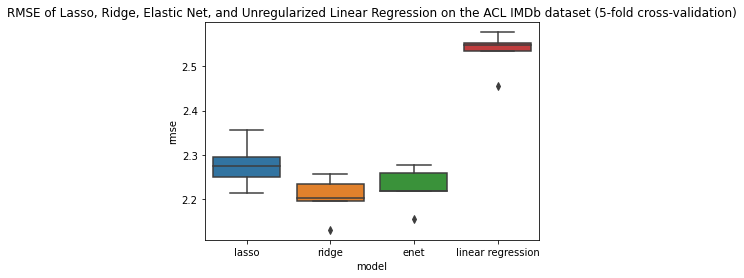

In [16]:
df = pd.DataFrame(results)

plt.title("RMSE of Lasso, Ridge, Elastic Net, and Unregularized Linear Regression on the ACL IMDb dataset (5-fold cross-validation)")
plt.xlabel("Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
sns.boxplot(data=df, x="model", y="rmse")
plt.savefig("../../results/imdb/acl_imdb_cross_validation_score_models.png",dpi=300,bbox_inches='tight',facecolor='white')
plt.show()


In [17]:
print(df.groupby('model').mean())
print(df.groupby('model').std())


                       rmse
model                      
enet               2.225680
lasso              2.277771
linear regression  2.533487
ridge              2.204123
                       rmse
model                      
enet               0.047162
lasso              0.053017
linear regression  0.046612
ridge              0.048057


In [31]:
import pickle
ROOT_PATH= '../../'
EXPORT_FOLDER = os.path.join(ROOT_PATH,'data/processed/imdb/')
with open(f"{ROOT_PATH}/feature_names.pickle","rb") as f:
    feature_names = pickle.load(f)

In [18]:
def evaluate_binary_classification(model):
    y_pred_binary = model.predict(X_test) > 5
    y_test_binary = y_test > 5
    return np.sum(y_pred_binary == y_test_binary) / y_pred_binary.shape[0]

In [46]:
print(f"Lasso Alpha:{lasso_alpha}\nRidge Alpha: {ridge_alpha}\nElastic Net Alpha: {enet_alpha}")

Lasso Alpha:0.00019999999999999998
Ridge Alpha: 0.9
Elastic Net Alpha: 0.0001


In [44]:


lasso = Lasso(alpha=lasso_alpha)
lasso.fit(X_train,y_train)
print(f"Number of non-zero covariates used by Lasso: {np.sum(lasso.coef_ != 0)}")

Number of non-zero covariates used by Lasso: 1987


In [66]:
ridge = Ridge(alpha=ridge_alpha)
ridge.fit(X_train,y_train)
threshold = 1e-5
print(f"Number of covariates > epsilon (epsilon = 1e-5) used by Ridge: {np.sum(np.abs(ridge.coef_) > threshold)}")

Number of covariates > epsilon (epsilon = 1e-5) used by Ridge: 51563


In [26]:
np.argsort(ridge.coef_)

array([50823,  3539, 31600, ...,  1959, 16623, 19734])

In [67]:
enet = ElasticNet(alpha=enet_alpha)
enet.fit(X_train,y_train)
print(f"Number of covariates > epsilon (epsilon = 1e-5) used by ElasticNet: {np.sum(np.abs(enet.coef_) > threshold)}")

Number of covariates > epsilon (epsilon = 1e-5) used by ElasticNet: 11074


In [22]:
linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)

LinearRegression()

In [43]:
for model_name, model in [
    ("lasso", lasso),
    ("ridge", ridge),
    ("enet", enet),
    ("linear regression",linear_reg)
]:
    accuracy = evaluate_binary_classification(model)
    rmse = mean_squared_error(model.predict(X_test),y_test) ** 0.5
    print(f"{model_name}: {accuracy*100:.3f}%, RMSE {rmse:.4f}") 
    print(top_features(model))


lasso: 84.632%, RMSE 2.2962
           feature  coefficient  abs_coeff
0            worst   -14.700391  14.700391
1            awful   -11.213276  11.213276
2        poisoning    10.387334  10.387334
3         favorite    10.074387  10.074387
4          amazing     9.681036   9.681036
5            units     9.199416   9.199416
6             mess    -8.766339   8.766339
7    disappointing    -8.744449   8.744449
8            fails    -8.684309   8.684309
9           chavez     8.499618   8.499618
10         nothing    -8.465546   8.465546
11        downhill    -8.417990   8.417990
12           swear    -8.350841   8.350841
13            pack    -8.312579   8.312579
14           great     8.280559   8.280559
15           today     8.190833   8.190833
16         tedious    -8.184335   8.184335
17          unlike     8.152186   8.152186
18       vengeance     8.093097   8.093097
19       ludicrous    -8.072383   8.072383
20  disappointment    -8.065351   8.065351
21       wonderful     8.0

In [24]:
X_train.shape

(10000, 51563)

In [42]:
# def top_features(model):
#     sorted_features = np.argsort(-np.abs(model.coef_))
#     # return top 20 along with coefficient
#     print('\n'.join([f'{feature_names[ind]}  {model.coef_[ind]}' for ind in sorted_features[:20]]))
import pandas as pd
import numpy as np

def top_features(model, k=50):
    coefs = model.coef_.ravel()
    idx = np.argsort(np.abs(coefs))[::-1][:k]
    return pd.DataFrame({
        "feature": [feature_names[i] for i in idx],
        "coefficient": [coefs[i] for i in idx],
        "abs_coeff": [abs(coefs[i]) for i in idx],
    }).sort_values("abs_coeff", ascending=False)


In [68]:
(lasso_alpha, ridge_alpha, enet_alpha)

(0.00019999999999999998, 0.9, 0.0001)